In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1857.64it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

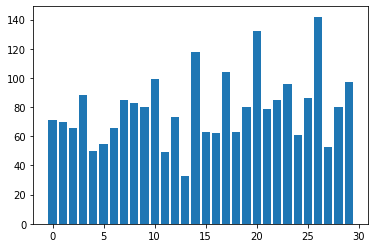

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

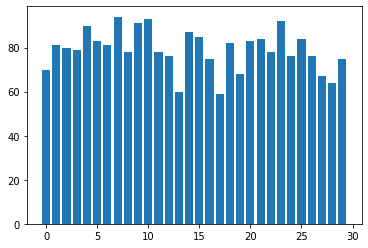

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=False
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes,print_f1=True,print_precision=False,print_recall=False, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        self.print_f1=print_f1
        self.print_precision=print_precision
        self.print_recall=print_recall
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            if self.print_precision:
                output['precision_{}'.format(i)]=results[0][i]
            if self.print_recall:
                output['recall_{}'.format(i)]=results[1][i]
            if self.print_f1:
                output['F1_{}'.format(i)]=results[2][i]

In [14]:
class MySequential(keras.Sequential):
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [15]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [16]:
from tensorflow.keras.layers import Conv2D

In [17]:
ConvLayer=Conv2D

In [18]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu1'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu2'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu3'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding='same',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu4'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 12, 1502, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 1500, 64)      640       
_________________________________________________________________
relu1 (LeakyReLU)            (None, 10, 1500, 64)      0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 10, 1500, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 750, 64)     

In [19]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [20]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
74/74 [==============================] - 12s 159ms/step - loss: 3.3563 - accuracy: 0.0794 - F1_0: 0.0351 - F1_1: 0.0038 - F1_2: 0.0000e+00 - F1_3: 0.0369 - F1_4: 0.0434 - F1_5: 0.0080 - F1_6: 0.0000e+00 - F1_7: 0.0631 - F1_8: 0.0663 - F1_9: 0.0543 - F1_10: 0.0199 - F1_11: 0.0000e+00 - F1_12: 0.0278 - F1_13: 0.0000e+00 - F1_14: 0.0402 - F1_15: 0.0577 - F1_16: 0.0000e+00 - F1_17: 0.0699 - F1_18: 0.0000e+00 - F1_19: 0.0048 - F1_20: 0.0883 - F1_21: 0.0694 - F1_22: 0.0517 - F1_23: 0.0268 - F1_24: 0.0425 - F1_25: 0.0491 - F1_26: 0.1946 - F1_27: 0.0000e+00 - F1_28: 0.0649 - F1_29: 0.0675 - val_loss: 6.1616 - val_accuracy: 0.0195 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1

74/74 [==============================] - 11s 144ms/step - loss: 2.1570 - accuracy: 0.3957 - F1_0: 0.1584 - F1_1: 0.1108 - F1_2: 0.3917 - F1_3: 0.3930 - F1_4: 0.3207 - F1_5: 0.3854 - F1_6: 0.1497 - F1_7: 0.4543 - F1_8: 0.4243 - F1_9: 0.2312 - F1_10: 0.3331 - F1_11: 0.1160 - F1_12: 0.4954 - F1_13: 0.0872 - F1_14: 0.3842 - F1_15: 0.3728 - F1_16: 0.2802 - F1_17: 0.4491 - F1_18: 0.0113 - F1_19: 0.4158 - F1_20: 0.4721 - F1_21: 0.3306 - F1_22: 0.3681 - F1_23: 0.3512 - F1_24: 0.4331 - F1_25: 0.3059 - F1_26: 0.6640 - F1_27: 0.0788 - F1_28: 0.1045 - F1_29: 0.3669 - val_loss: 4.0333 - val_accuracy: 0.0948 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.1042 - val_F1_3: 0.0000e+00 - val_F1_4: 0.1905 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.2963 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0870 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1176 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.2222 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 

74/74 [==============================] - 11s 145ms/step - loss: 1.2833 - accuracy: 0.6389 - F1_0: 0.4414 - F1_1: 0.3793 - F1_2: 0.6805 - F1_3: 0.5696 - F1_4: 0.6293 - F1_5: 0.6253 - F1_6: 0.4252 - F1_7: 0.7011 - F1_8: 0.7675 - F1_9: 0.7176 - F1_10: 0.7177 - F1_11: 0.3905 - F1_12: 0.8210 - F1_13: 0.3454 - F1_14: 0.6215 - F1_15: 0.5844 - F1_16: 0.7196 - F1_17: 0.5117 - F1_18: 0.4102 - F1_19: 0.7448 - F1_20: 0.7436 - F1_21: 0.6467 - F1_22: 0.5965 - F1_23: 0.6727 - F1_24: 0.6063 - F1_25: 0.5452 - F1_26: 0.8306 - F1_27: 0.4255 - F1_28: 0.4046 - F1_29: 0.6149 - val_loss: 3.5802 - val_accuracy: 0.1675 - val_F1_0: 0.0952 - val_F1_1: 0.2759 - val_F1_2: 0.0591 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4590 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0833 - val_F1_7: 0.3529 - val_F1_8: 0.2857 - val_F1_9: 0.2857 - val_F1_10: 0.0870 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1579 - val_F1_14: 0.1304 - val_F1_15: 0.5366 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_F1_18: 0.1176 - va

Epoch 20/100
74/74 [==============================] - 11s 144ms/step - loss: 0.7856 - accuracy: 0.7741 - F1_0: 0.6703 - F1_1: 0.6785 - F1_2: 0.7201 - F1_3: 0.7973 - F1_4: 0.8526 - F1_5: 0.7724 - F1_6: 0.8148 - F1_7: 0.7717 - F1_8: 0.8272 - F1_9: 0.7928 - F1_10: 0.7873 - F1_11: 0.4717 - F1_12: 0.9553 - F1_13: 0.8198 - F1_14: 0.7915 - F1_15: 0.7823 - F1_16: 0.6426 - F1_17: 0.7161 - F1_18: 0.7061 - F1_19: 0.8039 - F1_20: 0.8526 - F1_21: 0.8096 - F1_22: 0.8655 - F1_23: 0.7677 - F1_24: 0.6692 - F1_25: 0.7676 - F1_26: 0.8807 - F1_27: 0.6386 - F1_28: 0.6752 - F1_29: 0.6743 - val_loss: 2.4924 - val_accuracy: 0.3247 - val_F1_0: 0.3200 - val_F1_1: 0.2286 - val_F1_2: 0.0000e+00 - val_F1_3: 0.3733 - val_F1_4: 0.5672 - val_F1_5: 0.2143 - val_F1_6: 0.1600 - val_F1_7: 0.2000 - val_F1_8: 0.5581 - val_F1_9: 0.3125 - val_F1_10: 0.6588 - val_F1_11: 0.0392 - val_F1_12: 0.1154 - val_F1_13: 0.1951 - val_F1_14: 0.1702 - val_F1_15: 0.7826 - val_F1_16: 0.3529 - val_F1_17: 0.0364 - val_F1_18: 0.5217 - val_F1_19

Epoch 27/100
74/74 [==============================] - 11s 144ms/step - loss: 0.5098 - accuracy: 0.8657 - F1_0: 0.7906 - F1_1: 0.7974 - F1_2: 0.8730 - F1_3: 0.9160 - F1_4: 0.7437 - F1_5: 0.8873 - F1_6: 0.9165 - F1_7: 0.9171 - F1_8: 0.9155 - F1_9: 0.8789 - F1_10: 0.8605 - F1_11: 0.6848 - F1_12: 0.9678 - F1_13: 0.8856 - F1_14: 0.8984 - F1_15: 0.8494 - F1_16: 0.6697 - F1_17: 0.8397 - F1_18: 0.8927 - F1_19: 0.9164 - F1_20: 0.8875 - F1_21: 0.8475 - F1_22: 0.8954 - F1_23: 0.9158 - F1_24: 0.8282 - F1_25: 0.9220 - F1_26: 0.9061 - F1_27: 0.7103 - F1_28: 0.8265 - F1_29: 0.8414 - val_loss: 3.1211 - val_accuracy: 0.2753 - val_F1_0: 0.3256 - val_F1_1: 0.4848 - val_F1_2: 0.0531 - val_F1_3: 0.1852 - val_F1_4: 0.7294 - val_F1_5: 0.3077 - val_F1_6: 0.3871 - val_F1_7: 0.4211 - val_F1_8: 0.5965 - val_F1_9: 0.0755 - val_F1_10: 0.5455 - val_F1_11: 0.0645 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1081 - val_F1_14: 0.2857 - val_F1_15: 0.3226 - val_F1_16: 0.2400 - val_F1_17: 0.0000e+00 - val_F1_18: 0.2222 - val_F

Epoch 34/100
74/74 [==============================] - 11s 145ms/step - loss: 0.3808 - accuracy: 0.9050 - F1_0: 0.8661 - F1_1: 0.8707 - F1_2: 0.8889 - F1_3: 0.9050 - F1_4: 0.9074 - F1_5: 0.9167 - F1_6: 0.9089 - F1_7: 0.8794 - F1_8: 0.9334 - F1_9: 0.8627 - F1_10: 0.9364 - F1_11: 0.8792 - F1_12: 0.9295 - F1_13: 0.8568 - F1_14: 0.8895 - F1_15: 0.9359 - F1_16: 0.8713 - F1_17: 0.9095 - F1_18: 0.9022 - F1_19: 0.8800 - F1_20: 0.9099 - F1_21: 0.9033 - F1_22: 0.9053 - F1_23: 0.9546 - F1_24: 0.9048 - F1_25: 0.9234 - F1_26: 0.9732 - F1_27: 0.8490 - F1_28: 0.9058 - F1_29: 0.8745 - val_loss: 2.3617 - val_accuracy: 0.3935 - val_F1_0: 0.7317 - val_F1_1: 0.0909 - val_F1_2: 0.0000e+00 - val_F1_3: 0.4483 - val_F1_4: 0.5614 - val_F1_5: 0.2609 - val_F1_6: 0.3571 - val_F1_7: 0.2692 - val_F1_8: 0.5763 - val_F1_9: 0.6286 - val_F1_10: 0.5915 - val_F1_11: 0.2941 - val_F1_12: 0.1250 - val_F1_13: 0.2381 - val_F1_14: 0.3529 - val_F1_15: 0.6977 - val_F1_16: 0.5714 - val_F1_17: 0.2692 - val_F1_18: 0.5714 - val_F1_19

Epoch 41/100
74/74 [==============================] - 11s 147ms/step - loss: 0.2923 - accuracy: 0.9265 - F1_0: 0.9268 - F1_1: 0.9036 - F1_2: 0.8624 - F1_3: 0.8982 - F1_4: 0.9077 - F1_5: 0.8877 - F1_6: 0.8756 - F1_7: 0.8791 - F1_8: 0.8843 - F1_9: 0.8821 - F1_10: 0.9257 - F1_11: 0.8025 - F1_12: 0.9990 - F1_13: 0.7737 - F1_14: 0.9264 - F1_15: 0.9649 - F1_16: 0.8423 - F1_17: 0.8970 - F1_18: 0.8867 - F1_19: 0.9023 - F1_20: 0.9184 - F1_21: 0.9071 - F1_22: 0.9041 - F1_23: 0.9386 - F1_24: 0.9456 - F1_25: 0.8893 - F1_26: 0.9659 - F1_27: 0.8788 - F1_28: 0.9332 - F1_29: 0.8855 - val_loss: 2.5431 - val_accuracy: 0.3896 - val_F1_0: 0.5085 - val_F1_1: 0.5143 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5246 - val_F1_4: 0.6875 - val_F1_5: 0.3750 - val_F1_6: 0.5263 - val_F1_7: 0.3478 - val_F1_8: 0.5405 - val_F1_9: 0.4490 - val_F1_10: 0.2400 - val_F1_11: 0.1695 - val_F1_12: 0.1724 - val_F1_13: 0.5397 - val_F1_14: 0.3200 - val_F1_15: 0.4220 - val_F1_16: 0.5882 - val_F1_17: 0.4074 - val_F1_18: 0.5000 - val_F1_19

Epoch 48/100
74/74 [==============================] - 11s 145ms/step - loss: 0.2639 - accuracy: 0.9354 - F1_0: 0.8956 - F1_1: 0.8454 - F1_2: 0.9304 - F1_3: 0.9393 - F1_4: 0.9704 - F1_5: 0.8117 - F1_6: 0.9016 - F1_7: 0.9050 - F1_8: 0.9127 - F1_9: 0.9484 - F1_10: 0.9650 - F1_11: 0.8295 - F1_12: 0.9778 - F1_13: 0.8622 - F1_14: 0.9585 - F1_15: 0.9400 - F1_16: 0.8329 - F1_17: 0.9479 - F1_18: 0.9117 - F1_19: 0.9111 - F1_20: 0.9496 - F1_21: 0.9353 - F1_22: 0.9556 - F1_23: 0.9223 - F1_24: 0.9752 - F1_25: 0.8992 - F1_26: 0.9831 - F1_27: 0.9643 - F1_28: 0.8868 - F1_29: 0.9250 - val_loss: 3.3132 - val_accuracy: 0.3649 - val_F1_0: 0.6667 - val_F1_1: 0.3636 - val_F1_2: 0.0339 - val_F1_3: 0.5000 - val_F1_4: 0.5714 - val_F1_5: 0.3226 - val_F1_6: 0.6792 - val_F1_7: 0.3846 - val_F1_8: 0.6250 - val_F1_9: 0.3396 - val_F1_10: 0.6437 - val_F1_11: 0.0702 - val_F1_12: 0.1724 - val_F1_13: 0.3529 - val_F1_14: 0.1667 - val_F1_15: 0.8400 - val_F1_16: 0.1538 - val_F1_17: 0.3099 - val_F1_18: 0.7222 - val_F1_19: 0.

Epoch 55/100
74/74 [==============================] - 11s 145ms/step - loss: 0.2035 - accuracy: 0.9557 - F1_0: 0.9394 - F1_1: 0.9530 - F1_2: 0.8826 - F1_3: 0.9670 - F1_4: 0.9458 - F1_5: 0.9252 - F1_6: 0.9663 - F1_7: 0.9071 - F1_8: 0.9308 - F1_9: 0.9699 - F1_10: 0.9653 - F1_11: 0.9319 - F1_12: 1.0000 - F1_13: 0.9338 - F1_14: 0.9628 - F1_15: 0.9597 - F1_16: 0.9197 - F1_17: 0.9258 - F1_18: 0.9194 - F1_19: 0.9630 - F1_20: 0.9779 - F1_21: 0.9309 - F1_22: 0.9098 - F1_23: 0.9964 - F1_24: 0.9688 - F1_25: 0.9665 - F1_26: 0.9610 - F1_27: 0.9909 - F1_28: 0.9751 - F1_29: 0.9589 - val_loss: 2.4477 - val_accuracy: 0.4338 - val_F1_0: 0.6667 - val_F1_1: 0.3462 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5846 - val_F1_4: 0.7869 - val_F1_5: 0.2903 - val_F1_6: 0.3717 - val_F1_7: 0.1667 - val_F1_8: 0.5500 - val_F1_9: 0.7027 - val_F1_10: 0.5528 - val_F1_11: 0.1538 - val_F1_12: 0.3333 - val_F1_13: 0.1081 - val_F1_14: 0.4000 - val_F1_15: 0.7692 - val_F1_16: 0.3333 - val_F1_17: 0.2041 - val_F1_18: 0.6875 - val_F1_19

Epoch 62/100
74/74 [==============================] - 11s 145ms/step - loss: 0.1900 - accuracy: 0.9514 - F1_0: 0.9568 - F1_1: 0.9451 - F1_2: 0.9427 - F1_3: 0.9723 - F1_4: 0.9772 - F1_5: 0.9503 - F1_6: 0.9191 - F1_7: 0.9403 - F1_8: 0.9654 - F1_9: 0.9549 - F1_10: 0.9483 - F1_11: 0.9280 - F1_12: 0.9827 - F1_13: 0.9237 - F1_14: 0.9831 - F1_15: 0.9673 - F1_16: 0.9538 - F1_17: 0.9366 - F1_18: 0.8985 - F1_19: 0.9496 - F1_20: 0.9315 - F1_21: 0.9429 - F1_22: 0.9372 - F1_23: 0.8709 - F1_24: 0.9324 - F1_25: 0.9302 - F1_26: 0.9906 - F1_27: 0.9182 - F1_28: 0.9132 - F1_29: 0.9390 - val_loss: 2.5149 - val_accuracy: 0.4494 - val_F1_0: 0.7742 - val_F1_1: 0.5217 - val_F1_2: 0.0294 - val_F1_3: 0.6571 - val_F1_4: 0.7458 - val_F1_5: 0.3556 - val_F1_6: 0.5946 - val_F1_7: 0.3429 - val_F1_8: 0.6786 - val_F1_9: 0.7037 - val_F1_10: 0.6829 - val_F1_11: 0.6316 - val_F1_12: 0.1250 - val_F1_13: 0.2051 - val_F1_14: 0.4444 - val_F1_15: 0.8000 - val_F1_16: 0.3125 - val_F1_17: 0.4928 - val_F1_18: 0.2857 - val_F1_19: 0.

Epoch 69/100
74/74 [==============================] - 11s 146ms/step - loss: 0.1757 - accuracy: 0.9535 - F1_0: 0.9828 - F1_1: 0.9107 - F1_2: 0.9841 - F1_3: 0.9817 - F1_4: 0.9934 - F1_5: 0.8465 - F1_6: 0.9633 - F1_7: 0.9474 - F1_8: 0.9497 - F1_9: 0.9424 - F1_10: 0.9409 - F1_11: 0.9217 - F1_12: 0.9907 - F1_13: 0.9006 - F1_14: 0.9513 - F1_15: 0.9357 - F1_16: 0.9087 - F1_17: 0.8993 - F1_18: 0.9304 - F1_19: 0.9490 - F1_20: 0.9649 - F1_21: 0.9624 - F1_22: 0.9088 - F1_23: 0.9718 - F1_24: 0.9494 - F1_25: 0.9354 - F1_26: 0.9859 - F1_27: 0.9577 - F1_28: 0.8842 - F1_29: 0.9638 - val_loss: 2.5313 - val_accuracy: 0.4468 - val_F1_0: 0.4615 - val_F1_1: 0.4103 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5797 - val_F1_4: 0.6102 - val_F1_5: 0.1333 - val_F1_6: 0.4667 - val_F1_7: 0.3158 - val_F1_8: 0.5366 - val_F1_9: 0.5574 - val_F1_10: 0.6000 - val_F1_11: 0.4211 - val_F1_12: 0.1702 - val_F1_13: 0.3462 - val_F1_14: 0.2703 - val_F1_15: 0.8511 - val_F1_16: 0.3784 - val_F1_17: 0.3902 - val_F1_18: 0.7273 - val_F1_19

Epoch 76/100
74/74 [==============================] - 11s 145ms/step - loss: 0.1391 - accuracy: 0.9649 - F1_0: 0.9911 - F1_1: 0.9838 - F1_2: 0.9862 - F1_3: 0.9488 - F1_4: 0.9737 - F1_5: 0.9292 - F1_6: 0.9453 - F1_7: 0.9768 - F1_8: 0.9367 - F1_9: 0.9880 - F1_10: 0.9543 - F1_11: 0.8914 - F1_12: 0.9765 - F1_13: 0.9994 - F1_14: 0.9519 - F1_15: 0.9112 - F1_16: 0.8941 - F1_17: 0.9722 - F1_18: 0.9754 - F1_19: 0.9869 - F1_20: 0.9808 - F1_21: 0.9595 - F1_22: 0.9668 - F1_23: 0.9643 - F1_24: 0.9873 - F1_25: 0.9584 - F1_26: 0.9536 - F1_27: 0.9824 - F1_28: 0.9151 - F1_29: 0.9927 - val_loss: 3.4234 - val_accuracy: 0.3351 - val_F1_0: 0.7143 - val_F1_1: 0.3429 - val_F1_2: 0.0000e+00 - val_F1_3: 0.1667 - val_F1_4: 0.8169 - val_F1_5: 0.1961 - val_F1_6: 0.5556 - val_F1_7: 0.3448 - val_F1_8: 0.5641 - val_F1_9: 0.3774 - val_F1_10: 0.6102 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.1951 - val_F1_14: 0.3077 - val_F1_15: 0.4242 - val_F1_16: 0.3333 - val_F1_17: 0.1500 - val_F1_18: 0.2000 - v

Epoch 83/100
74/74 [==============================] - 11s 144ms/step - loss: 0.1231 - accuracy: 0.9717 - F1_0: 0.9642 - F1_1: 0.8908 - F1_2: 0.9155 - F1_3: 0.9987 - F1_4: 0.9771 - F1_5: 0.9619 - F1_6: 0.9098 - F1_7: 0.9544 - F1_8: 0.9827 - F1_9: 0.9415 - F1_10: 0.9819 - F1_11: 0.8869 - F1_12: 1.0000 - F1_13: 0.9601 - F1_14: 0.9856 - F1_15: 0.9708 - F1_16: 0.9644 - F1_17: 0.9779 - F1_18: 0.9699 - F1_19: 0.9837 - F1_20: 0.9884 - F1_21: 0.9787 - F1_22: 0.9449 - F1_23: 0.9764 - F1_24: 0.9842 - F1_25: 0.9390 - F1_26: 0.9936 - F1_27: 0.9720 - F1_28: 0.9540 - F1_29: 0.9686 - val_loss: 2.4945 - val_accuracy: 0.4519 - val_F1_0: 0.5517 - val_F1_1: 0.2759 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5231 - val_F1_4: 0.7333 - val_F1_5: 0.2778 - val_F1_6: 0.5161 - val_F1_7: 0.4000 - val_F1_8: 0.5652 - val_F1_9: 0.7907 - val_F1_10: 0.7789 - val_F1_11: 0.2424 - val_F1_12: 0.1961 - val_F1_13: 0.4706 - val_F1_14: 0.3448 - val_F1_15: 0.6567 - val_F1_16: 0.5882 - val_F1_17: 0.4598 - val_F1_18: 0.5854 - val_F1_19

Epoch 90/100
74/74 [==============================] - 11s 145ms/step - loss: 0.1186 - accuracy: 0.9654 - F1_0: 0.9640 - F1_1: 0.9160 - F1_2: 0.9168 - F1_3: 0.9898 - F1_4: 0.9738 - F1_5: 0.9200 - F1_6: 0.9184 - F1_7: 0.9213 - F1_8: 0.9959 - F1_9: 0.9645 - F1_10: 0.9851 - F1_11: 0.8374 - F1_12: 0.9821 - F1_13: 0.9579 - F1_14: 0.9691 - F1_15: 0.9867 - F1_16: 0.9133 - F1_17: 0.9820 - F1_18: 0.9758 - F1_19: 0.9469 - F1_20: 0.9887 - F1_21: 0.9582 - F1_22: 0.9318 - F1_23: 0.9543 - F1_24: 0.9766 - F1_25: 0.9514 - F1_26: 0.9871 - F1_27: 0.9673 - F1_28: 0.9479 - F1_29: 0.9175 - val_loss: 2.8092 - val_accuracy: 0.4636 - val_F1_0: 0.7200 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0377 - val_F1_3: 0.5075 - val_F1_4: 0.7209 - val_F1_5: 0.2857 - val_F1_6: 0.7797 - val_F1_7: 0.1798 - val_F1_8: 0.6333 - val_F1_9: 0.6500 - val_F1_10: 0.7273 - val_F1_11: 0.6400 - val_F1_12: 0.1277 - val_F1_13: 0.3200 - val_F1_14: 0.3125 - val_F1_15: 0.8000 - val_F1_16: 0.5000 - val_F1_17: 0.5679 - val_F1_18: 0.9333 - val_F1_19

Epoch 97/100
74/74 [==============================] - 11s 145ms/step - loss: 0.1052 - accuracy: 0.9721 - F1_0: 0.9993 - F1_1: 0.9163 - F1_2: 0.9690 - F1_3: 0.9889 - F1_4: 0.9407 - F1_5: 0.9241 - F1_6: 0.9837 - F1_7: 0.9658 - F1_8: 0.9454 - F1_9: 0.9512 - F1_10: 0.9824 - F1_11: 0.9500 - F1_12: 0.9733 - F1_13: 0.9733 - F1_14: 0.9764 - F1_15: 0.9810 - F1_16: 0.9417 - F1_17: 0.9734 - F1_18: 0.9051 - F1_19: 0.9687 - F1_20: 0.9568 - F1_21: 0.9927 - F1_22: 0.9396 - F1_23: 0.9902 - F1_24: 0.9255 - F1_25: 0.9933 - F1_26: 0.9817 - F1_27: 0.9837 - F1_28: 0.9355 - F1_29: 0.9469 - val_loss: 2.4955 - val_accuracy: 0.4805 - val_F1_0: 0.7317 - val_F1_1: 0.4571 - val_F1_2: 0.0000e+00 - val_F1_3: 0.5915 - val_F1_4: 0.7294 - val_F1_5: 0.3692 - val_F1_6: 0.6923 - val_F1_7: 0.4000 - val_F1_8: 0.7407 - val_F1_9: 0.4444 - val_F1_10: 0.7071 - val_F1_11: 0.2632 - val_F1_12: 0.1304 - val_F1_13: 0.5902 - val_F1_14: 0.3333 - val_F1_15: 0.8235 - val_F1_16: 0.3721 - val_F1_17: 0.4082 - val_F1_18: 0.6667 - val_F1_19

In [40]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'augented_2.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [22]:
#model.save_weights('phase_1_weights_100_epochs')

In [23]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [24]:
training_history_file

'training_history/tmp3.json'

In [25]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [26]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [27]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

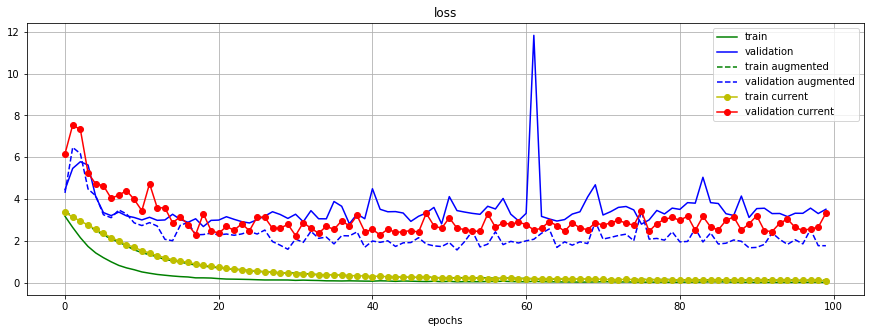

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

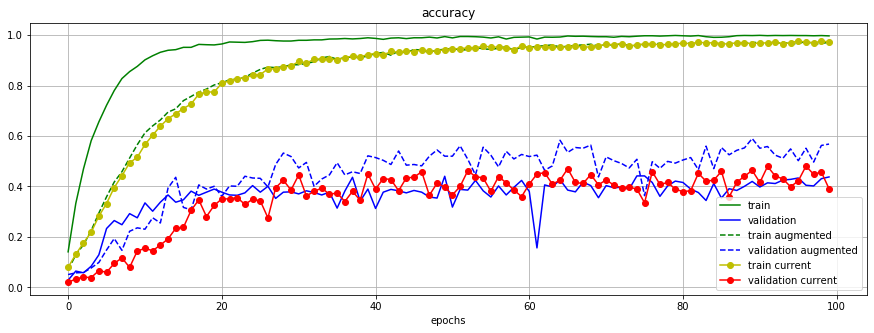

In [29]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

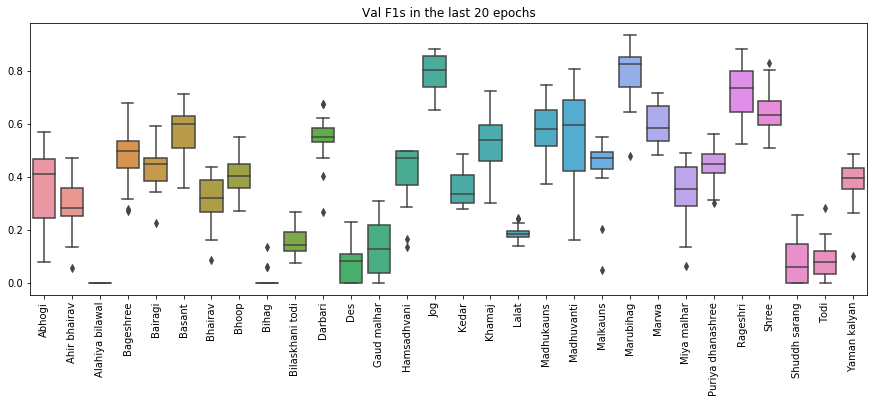

In [30]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

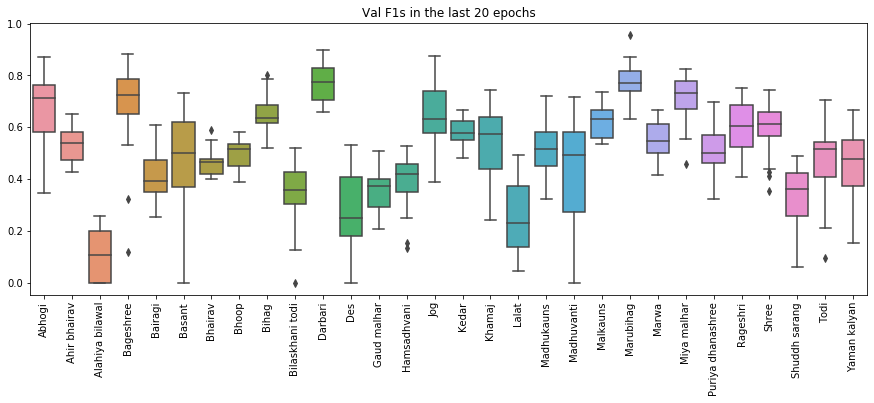

In [31]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

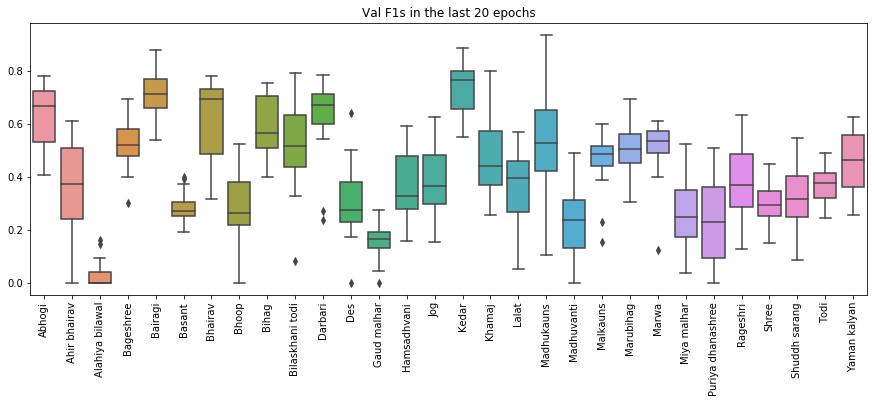

In [32]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

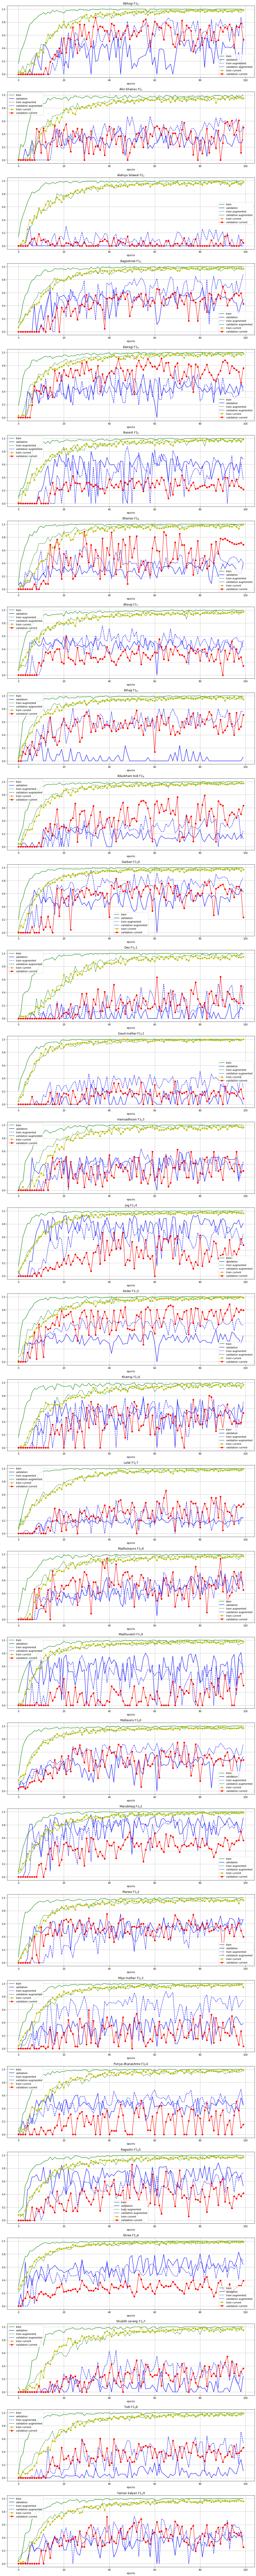

In [33]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [34]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [35]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


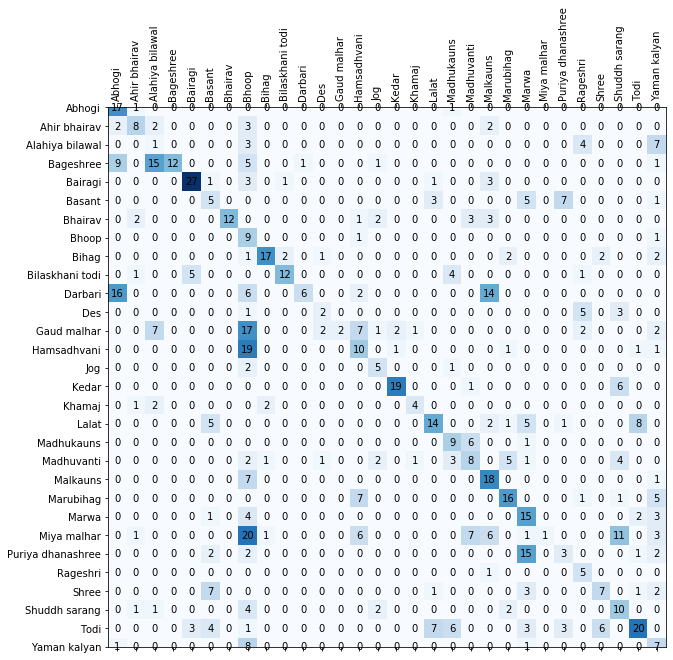

In [36]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [37]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [38]:
precision,recall,f1=process_confusion_matrix(cm)

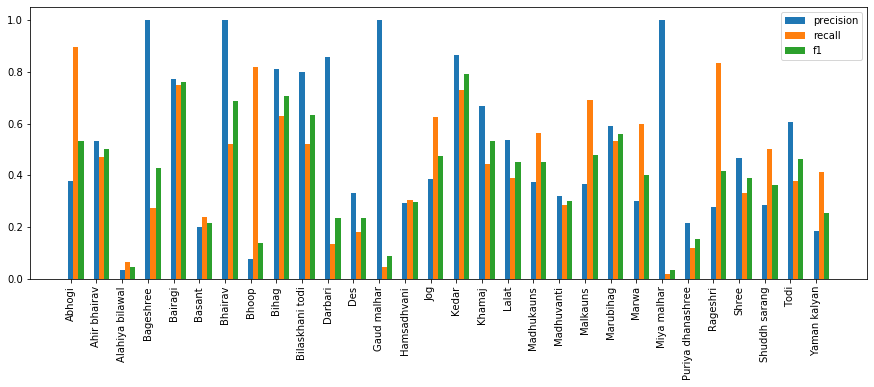

In [39]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>